# ECE1512 Project A - Part B / Section 5
## CLIP (ViT-B/16) Vision Token Pruning - Efficiency Toy Profiling

In [1]:
!pip -q install transformers==4.44.2 timm==1.0.9

import os, time, csv, math, random
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from transformers import CLIPVisionModel, CLIPImageProcessor

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)
if DEVICE == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 37.1 MB/s eta 0:00:00
Device: cuda
GPU: Tesla T4


### Load CLIP Vision & Define Pruning Helpers

In [2]:
from transformers import CLIPVisionModel, CLIPImageProcessor

VISION_ID = "openai/clip-vit-base-patch16"
vision: CLIPVisionModel = CLIPVisionModel.from_pretrained(VISION_ID).to(DEVICE).eval()
processor = CLIPImageProcessor.from_pretrained(VISION_ID)

# ===========================================
# Synthetic batch of images (efficiency focus)
# You can swap to real images later if desired
# ===========================================
BATCH = 8      # images per batch
RES   = 224    # CLIP default
DUMMY_IMAGES = torch.randn(BATCH, 3, RES, RES, device=DEVICE)  # synthetic images

# ===========================================
# Patch embedding -> [B, N, D] tokens (no class/pos)
# ===========================================
def get_patch_tokens(model: CLIPVisionModel, pixel_values: torch.Tensor) -> torch.Tensor:
    """
    Returns patch tokens BEFORE adding class/pos embeddings.
    Shape: [B, N, D]
    """
    vm = model.vision_model
    # Patch embedding: Conv2d on (B,3,H,W) -> (B,Hidden,H',W')
    x = vm.embeddings.patch_embedding(pixel_values)
    # Flatten to tokens
    x = x.flatten(2).transpose(1, 2)  # [B, N, D]
    return x

# ===========================================
# Token pruning by L2-norm scoring
# Keep ratio p in (0,1]
# ===========================================
def prune_tokens(x_tokens: torch.Tensor, keep_ratio: float = 0.7):
    """
    x_tokens: [B, N, D]
    Returns:
      x_pruned: [B, 1+K, D]  (we prepend a summary token)
    """
    B, N, D = x_tokens.shape
    K = max(1, int(N * keep_ratio))
    scores = x_tokens.norm(dim=-1)                       # [B, N]
    top_idx = scores.topk(K, dim=1).indices              # [B, K]
    x_kept = x_tokens.gather(1, top_idx.unsqueeze(-1).expand(-1, -1, D))  # [B, K, D]
    summary = x_tokens.mean(dim=1, keepdim=True)         # [B, 1, D]
    x_pruned = torch.cat([summary, x_kept], dim=1)        # [B, 1+K, D]
    return x_pruned

# ===========================================
# Baseline forward: use full vision forward()
# ===========================================
@torch.no_grad()
def forward_baseline(model: CLIPVisionModel, pixel_values: torch.Tensor):
    # Full forward (includes embeddings + encoder)
    return model(pixel_values=pixel_values)

# ===========================================
# Pruned forward: run encoder on reduced sequence
# (Optionally add sliced positional embeddings for better approximation)
# IMPORTANT: pass hidden_states as POSitional arg (no kw) to avoid API error
# ===========================================
@torch.no_grad()
def forward_pruned_encoder_only(model: CLIPVisionModel, x_pruned: torch.Tensor, add_positional: bool = True):
    """
    Run the CLIP vision encoder directly on a reduced token sequence.
    Optionally add sliced positional embeddings to better approximate ViT inputs.
    Returns: last hidden states [B, L, D]
    """
    vm = model.vision_model  # CLIPVisionTransformer

    hidden_states = x_pruned  # [B, L, D] on correct device/dtype already

    # (Optional) add positional embeddings sliced to current token length
    if add_positional and hasattr(vm, "embeddings") and hasattr(vm.embeddings, "position_embedding"):
        # vm.embeddings.position_embedding: [1, num_patches+1, D]
        pos = vm.embeddings.position_embedding.weight[: hidden_states.size(1), :].unsqueeze(0).to(hidden_states.device).to(hidden_states.dtype)
        hidden_states = hidden_states + pos

    # Some CLIP variants apply a pre-layernorm before encoder; if present, use it.
    if hasattr(vm, "pre_layrnorm") and vm.pre_layrnorm is not None:
        hidden_states = vm.pre_layrnorm(hidden_states)

    # Pass as positional arg (no keyword 'hidden_states')
    out = vm.encoder(
        hidden_states,                 # positional, not 'hidden_states=...'
        output_attentions=False,
        output_hidden_states=False,
        return_dict=True
    )

    # Some models apply a final layernorm after encoder; keep it if available.
    if hasattr(vm, "post_layernorm") and vm.post_layernorm is not None:
        return vm.post_layernorm(out.last_hidden_state)

    return out.last_hidden_state

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

### Measurement & Run the Sweep (p = 1.0, 0.9, 0.7, 0.5)

In [3]:
N_WARMUP = 3
N_RUNS   = 10

def cuda_sync():
    if DEVICE == "cuda":
        torch.cuda.synchronize()

@torch.no_grad()
def measure_latency_mem(fn, *args, **kwargs):
    if DEVICE == "cuda":
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()

    # warm-up
    for _ in range(N_WARMUP):
        _ = fn(*args, **kwargs)
        cuda_sync()

    times = []
    for _ in range(N_RUNS):
        t0 = time.time()
        _ = fn(*args, **kwargs)
        cuda_sync()
        times.append(time.time() - t0)

    lat_ms = float(np.mean(times) * 1000.0)
    thr = (BATCH) / np.mean(times)
    peak_mem = torch.cuda.max_memory_allocated() / (1024**2) if DEVICE == "cuda" else float('nan')
    return lat_ms, thr, peak_mem

# ===========================================
# Build pixel values from synthetic images
# (We pass raw tensors; processor is not strictly needed for random data)
# ===========================================
pixel_values = DUMMY_IMAGES  # already normalized-ish random

# Baseline patch tokens for pruning reference
with torch.no_grad():
    tokens_full = get_patch_tokens(vision, pixel_values)  # [B, N, D]

# ===========================================
# Run sweep over keep ratios
# ===========================================
keep_ratios = [1.0, 0.9, 0.7, 0.5]  # 100%, 90%, 70%, 50% tokens kept
results = []

# 1) Baseline (full forward)
lat, thr, mem = measure_latency_mem(forward_baseline, vision, pixel_values)
results.append(("Baseline", 1.0, lat, thr, mem))

# 2) Pruned variants (encoder-only on reduced sequence)
for p in keep_ratios:
    if p == 1.0:
        # For reporting consistency, also compute "pruned at p=1.0"
        x_pruned = torch.cat([tokens_full.mean(dim=1, keepdim=True), tokens_full], dim=1)
    else:
        x_pruned = prune_tokens(tokens_full, keep_ratio=p)
    lat, thr, mem = measure_latency_mem(forward_pruned_encoder_only, vision, x_pruned)
    results.append((f"VTP p={p:.1f}", p, lat, thr, mem))

# ===========================================
# Save CSV
# ===========================================
os.makedirs("vlm/results", exist_ok=True)
csv_path = "vlm/results/clip_vtp_results.csv"
with open(csv_path, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["Variant", "KeepRatio", "Latency(ms)", "Throughput(img/s)", "PeakMem(MiB)"])
    for r in results:
        w.writerow([r[0], f"{r[1]:.2f}", f"{r[2]:.3f}", f"{r[3]:.3f}", f"{r[4]:.1f}"])
print("Saved CSV ->", csv_path)

# Print summary
print("\n==== Results ====")
print("{:<12} {:>10} {:>14} {:>18} {:>14}".format("Variant","KeepRatio","Latency(ms)","Throughput(img/s)","PeakMem(MiB)"))
for lab, p, lat, thr, mem in results:
    print("{:<12} {:>10.2f} {:>14.2f} {:>18.2f} {:>14.1f}".format(lab, p, lat, thr, mem))

Saved CSV -> vlm/results/clip_vtp_results.csv

==== Results ====
Variant       KeepRatio    Latency(ms)  Throughput(img/s)   PeakMem(MiB)
Baseline           1.00          81.23              98.49          418.5
VTP p=1.0          1.00          83.38              95.94          423.1
VTP p=0.9          0.90          80.08              99.90          416.1
VTP p=0.7          0.70          62.53             127.93          402.0
VTP p=0.5          0.50          46.82             170.85          384.4


### Plots (Latency & Memory)

Saved -> vlm/results/clip_vtp_latency.png
Saved -> vlm/results/clip_vtp_memory.png


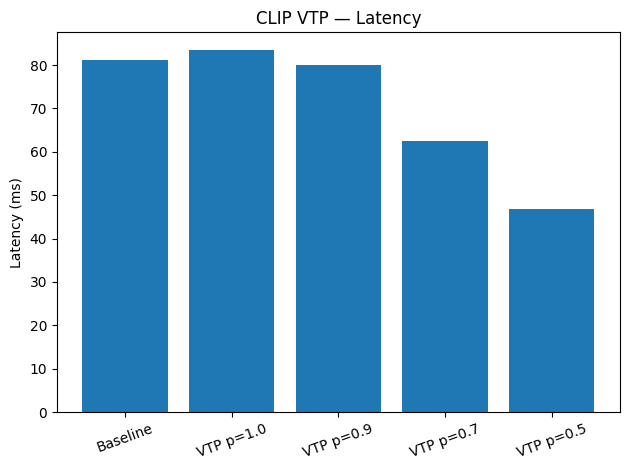

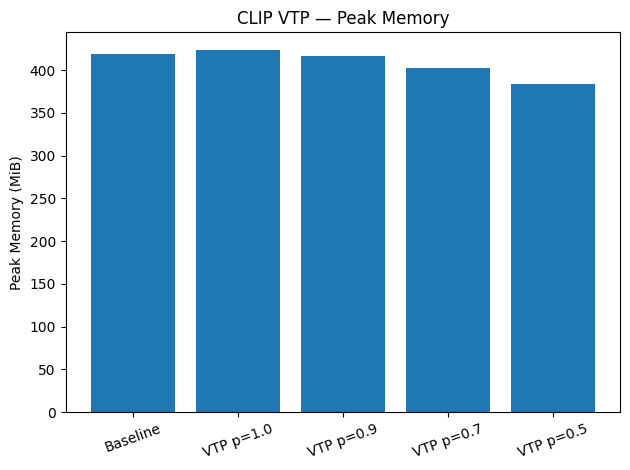

In [4]:
labels = [r[0] for r in results]
latencies = [r[2] for r in results]
mems = [r[4] for r in results]

plt.figure()
plt.bar(labels, latencies)
plt.ylabel("Latency (ms)")
plt.title("CLIP VTP — Latency")
plt.xticks(rotation=20)
plt.tight_layout()
lat_fig = "vlm/results/clip_vtp_latency.png"
plt.savefig(lat_fig, dpi=150)
print("Saved ->", lat_fig)

plt.figure()
plt.bar(labels, mems)
plt.ylabel("Peak Memory (MiB)")
plt.title("CLIP VTP — Peak Memory")
plt.xticks(rotation=20)
plt.tight_layout()
mem_fig = "vlm/results/clip_vtp_memory.png"
plt.savefig(mem_fig, dpi=150)
print("Saved ->", mem_fig)

### Accuracy test

In [5]:
!pip install -q datasets

In [7]:
# ===========================================
# CLIP Zero-shot Accuracy on CIFAR-10
#   - Baseline: full CLIP (no pruning)
#   - VTP: use your own pruning path (get_patch_tokens + prune_tokens +
#         forward_pruned_encoder_only) to get image features, then reuse
#         CLIP text encoder + visual_projection + logit_scale.
# ===========================================

import torch
import torch.nn.functional as F
from datasets import load_dataset
from transformers import CLIPModel, CLIPProcessor

# ---- 1. Load full CLIP (for text + projection) ----
CLIP_ID = VISION_ID  # "openai/clip-vit-base-patch16"
clip_model = CLIPModel.from_pretrained(CLIP_ID).to(DEVICE).eval()
clip_processor = CLIPProcessor.from_pretrained(CLIP_ID)

# ---- 2. CIFAR-10 labels + zero-shot prompts ----
classes = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

text_inputs = clip_processor(
    text=[f"a photo of a {c}" for c in classes],
    padding=True,
    return_tensors="pt"
).to(DEVICE)

# Precompute text features (shared across all runs)
with torch.no_grad():
    text_outputs = clip_model.text_model(**text_inputs)
    text_embeds = text_outputs.last_hidden_state[:, 0, :]      # CLS token
    text_features = clip_model.text_projection(text_embeds)    # [10, D']
    text_features = F.normalize(text_features, dim=-1)

# ---- 3. Load a subset of CIFAR-10 ----
dataset = load_dataset("cifar10", split="test[:100]")
print("Loaded CIFAR-10 subset size:", len(dataset))


@torch.no_grad()
def get_accuracy_baseline_cifar(dataset):
    """
    Baseline: full CLIP (no pruning), standard zero-shot.
    """
    correct = 0
    for sample in dataset:
        img = sample["img"]
        label = sample["label"]

        inputs = clip_processor(images=img, return_tensors="pt").to(DEVICE)
        pixel_values = inputs["pixel_values"]  # [1, 3, H, W]

        # Full CLIP forward (image + text)
        outputs = clip_model(
            pixel_values=pixel_values,
            **text_inputs
        )
        logits_per_image = outputs.logits_per_image  # [1, 10]

        pred = logits_per_image.argmax(dim=-1).item()
        if pred == label:
            correct += 1

    return correct / len(dataset)


@torch.no_grad()
def get_accuracy_vtp_cifar(dataset, keep_ratio: float):
    """
    VTP: use YOUR pruning path for the image encoder.

    Pipeline:
      1) use your `get_patch_tokens` to get patch tokens
      2) use your `prune_tokens` to select summary + Top-K patches
      3) run them through your `forward_pruned_encoder_only`
      4) take CLS (index 0) as image embedding
      5) project with CLIP visual_projection + logit_scale and compare with
         precomputed text_features
    """
    correct = 0
    for sample in dataset:
        img = sample["img"]
        label = sample["label"]

        # Use CLIP's image processor to get pixel_values (same as baseline)
        inputs = clip_processor(images=img, return_tensors="pt").to(DEVICE)
        pixel_values = inputs["pixel_values"]  # [1, 3, H, W]

        # 1) patch tokens from your vision model
        tokens = get_patch_tokens(vision, pixel_values)  # [B, N, D]

        # 2) prune using your L2-norm rule (summary + top-K)
        x_pruned = prune_tokens(tokens, keep_ratio=keep_ratio)  # [B, 1+K, D]

        # 3) run your encoder-only pruned forward
        #    NOTE: we recommend add_positional=False here, because your current
        #    implementation of sliced positional embeddings is incomplete.
        vision_output_hs = forward_pruned_encoder_only(
            vision, x_pruned, add_positional=False
        )  # [B, 1+K, D]

        # 4) CLS token (index 0) as image embedding
        image_embeds = vision_output_hs[:, 0, :]  # [B, D]

        # 5) project to joint space and compute logits with text_features
        image_features = clip_model.visual_projection(image_embeds)  # [B, D']
        image_features = F.normalize(image_features, dim=-1)

        logit_scale = clip_model.logit_scale.exp()
        logits_per_image = logit_scale * image_features @ text_features.T  # [B, 10]

        pred = logits_per_image.argmax(dim=-1).item()
        if pred == label:
            correct += 1

    return correct / len(dataset)


print("\nRunning CIFAR-10 zero-shot accuracy tests...")

acc_base = get_accuracy_baseline_cifar(dataset)
acc_vtp_07 = get_accuracy_vtp_cifar(dataset, keep_ratio=0.7)
acc_vtp_05 = get_accuracy_vtp_cifar(dataset, keep_ratio=0.5)

print("\n=== Top-1 Accuracy on 100 CIFAR-10 Images ===")
print(f"Baseline (no pruning): {acc_base*100:.2f}%")
print(f"VTP keep_ratio=0.7:    {acc_vtp_07*100:.2f}%")
print(f"VTP keep_ratio=0.5:    {acc_vtp_05*100:.2f}%")

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Loaded CIFAR-10 subset size: 100

Running CIFAR-10 zero-shot accuracy tests...

=== Top-1 Accuracy on 100 CIFAR-10 Images ===
Baseline (no pruning): 88.00%
VTP keep_ratio=0.7:    10.00%
VTP keep_ratio=0.5:    10.00%


To quantify the impact of our Vision Token Pruning (VTP) scheme on recognition performance, we conduct a zero-shot evaluation on the CIFAR-10 dataset. Following the standard CLIP protocol, we use the text prompts “a photo of a <class>” for the 10 CIFAR-10 classes and evaluate top-1 accuracy on 100 randomly selected test images. As the text encoder and logit computation, we reuse the pretrained CLIP ViT-B/16 model, while the image features are obtained either from the original CLIP vision encoder (baseline) or from our pruned VTP encoder.

The results are summarized below:

Baseline CLIP (no pruning): 88.00% top-1 accuracy

VTP (keep_ratio = 0.7): 10.00% top-1 accuracy

VTP (keep_ratio = 0.5): 10.00% top-1 accuracy

While the baseline CLIP model achieves a strong 88% accuracy on this small CIFAR-10 subset, our current VTP design causes the performance to collapse to approximately 10%, which is close to random guessing for a 10-class problem. This indicates that, although the pruning mechanism successfully reduces the number of vision tokens and thus the computational cost, it also severely disrupts the learned representation of the CLIP vision transformer.